---
title: Week 2 - PCA (principal component analysis) for GRACE and GRACE-FO mascon data
subtitle: Perform signal separation of GRACE data with PCA and EOF (empirical orthogonal function) analysis
authors:
  - name: Katrin Bentel (katrin.bentel@ethz.ch)
---

:::{important} Learning Goals &#9971;
- [ ] I can prepare the GRACE/GRACE-FO (or any other) data set for PCA/EOF analysis (centered data matrix)
- [ ] I can perform PCA/EOF analysis in Python
- [ ] I can explain the equations behind PCA
- [ ] I can plot the results
- [ ] I can interpret the results (EOF patterns, PC time series, and variance expressed)
- [ ] I can perform simple selection techniques for the dominant modes and explain more rigorous approaches
- [ ] I can reconstruct the data and explain the benefits of PCA/EOF analysis
- [ ] I can handle gaps in the data appropriately
:::

:::{attention} Questions
Don't hesitate to ask any question that might be coming up. If you think your question could be relevant to others as well, please post it in the [**Moodle forum**](https://moodle-app2.let.ethz.ch/mod/forum/view.php?id=1187440). Or you can just contact me by email.

____

## Table of Contents
#### [](#h-prepare-data)

#### [](#h-PCA-global)

#### [](#h-data-reconstruction)

#### [](#h-gaps)

#### [](#h-regional)

#### [](#h-outlook-feedback)


_____

(h-prepare-data)=
# 1. Get and prepare GRACE data

:::{tip} _Exercise 1:_ Load the GRACE and GRACE-FO mascon data set RL06.3_v04 from JPL and prepare the data for PCA/EOF analysis.
- The required data is  the same data set as the one we worked with last week. It is called `GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc`. Please refer to the routines from last week to get the data ready. To load the data, adjust the file path so that you can use last weeks data which is stored in the data folder.

- The data has to be arranged in a rectangular matrix, with time along the first dimension and location along the second dimension. Each monthly field should be in a row and each column represents the time series for one pixel. Please also refer to the slides.

- The data has to be centered, it needs to be true anomalies. Therefore, remove the time mean from each grid location
:::

#### &#128187; Coding starts here

The first code cell loads the Python libraries and you can continue with your code by adding more cells below.

In [1]:
# reads the .nc and .nc4 files
import netCDF4 as nc # library for working with NetCDF files, this is for large datasets
# miscellaneous operating system interfaces
import os # helps with file handling

# visualizes the data
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

#processes the data
import numpy as np #helps with numerical calculations
import pandas as pd

# helps visualize the data
import cartopy.crs as ccrs 
from cartopy.mpl.geoaxes import GeoAxes

from datetime import datetime # helps with handling dates and times

from sklearn.decomposition import PCA

from netCDF4 import num2date # converts the time variable ni the NetCDF into actual human.readable dates

In [2]:
# LOAD DATA
file_path = '../homework1/data/GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc'

# Check if the file exists
if os.path.exists(file_path):
    mascons = nc.Dataset(file_path)
else:
    raise FileNotFoundError(f"File not found: {file_path}")

# short alternative, without checking the file path:
mascons = nc.Dataset('../homework1/data/GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc')

In [46]:
# ARRANGING DATA TASK

# Extract relevant variables
time = mascons.variables['time'][:]
latitude = mascons.variables['lat'][:]
longitude = mascons.variables['lon'][:]
lwe_thickness = mascons.variables['lwe_thickness'][:]  # Example variable (adjust if needed)

#print(f'this is the time: {time}')
#print(f'this is the latitude: {latitude}')
#print(f'this is the longitude: {longitude}')
#print(f'this is the lwe_thickness: {latitude}')

# Reshape data 
# Convert time to datetime objects
time_units = mascons.variables['time'].units  # Get time units
calendar = mascons.variables['time'].calendar  # Get calendar type (if available)
# num2date function num2date(input of time that needs to be converted, unit that is wished, converts it)
dates = num2date(time, units=time_units, calendar=calendar)  # Convert time to datetime objects

# Extract year and month from dates
time_years = np.array([date.year for date in dates])
time_months = np.array([date.month for date in dates])

# Reshape data
num_time_steps = data_variable.shape[0]  # Time dimension
num_lat = data_variable.shape[1]  # Latitude dimension
num_lon = data_variable.shape[2]  # Longitude dimension

# Flatten spatial dimensions
reshaped_data = data_variable.reshape(num_time_steps, num_lat * num_lon)

# Transpose to match the required format (each row = pixel, each column = time series)
reshaped_data = reshaped_data.T

# Remove time mean to compute anomalies (centering the data)
time_mean = np.mean(reshaped_data, axis=1, keepdims=True)  # Compute mean for each location (row-wise)
data_centered = reshaped_data - time_mean  # Subtract mean from each time series

# Print shape for verification
print("data centered data shape:", anomalies.shape)  # Expected: (num_lat * num_lon, num_time_steps)
print("Unique Years in Data:", np.unique(time_years))
print("Unique Months in Data:", np.unique(time_months))


data centered data shape: (259200, 239)
Unique Years in Data: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023 2024]
Unique Months in Data: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [37]:
#try something
print(num_time_steps)
print(num_lat)
print(num_lon)

239
360
720


:::{hint} On Jupyternaut or your favourite chatbot &#9756;
:class: dropdown
- You may work with a chatbot also in this exercise. In case you used Jupyternaut with the provided configuration, this configuration is still set in Jupyternaut and you can continue to use it. 
- Everything that was mentioned about good practise and the use of a LLM (large language model) in the last homework still holds, and please keep in mind that it is crucially important to understand all the code that you use in your notebook (if you don't understand some code in detail, ask your chatbot and **test** the functionality).
- Since today's exercises are less plotting-focussed, the support you can get from a chatbot might be bit different to last week.
:::

_____

(h-PCA-global)=
# 2. Perform EOF analysis of the entire data set

:::{tip} _Exercise 2:_ Perform EOF analysis
Take the data matrix which you just prepared in exercise 1 and do EOF analysis of this data with the routines from `sklearn`. The required packages have already been imported above. Please refer to PCA demo example notebook where the routines are used on synthetic data. Add your code cells below.
:::

#### DOING AN EOF ANALYSIS ON THE DATA


In [47]:
# Apply EOF (PCA) analysis
pca = PCA(n_components=5)  # Extract first 5 EOFs
pca.fit(data_centered)
transformed_data = pca.transform(data_centered)
explained_variance = pca.explained_variance_ratio_  # Get explained variance for each mode


:::{tip} _Exercise 3:_ Plot the first few modes
Now it is time to reuse you routines from last week to plot maps and time series. For the first few modes, plot the EOF patterns the PC time series and the explained variance value. Arrange plots next to each other to get a better overview of your results.
:::


In [53]:
print(len(data_centered[0]))
print(len(data_centered[1])

SyntaxError: incomplete input (3456576411.py, line 2)

TypeError: Invalid shape (239,) for image data

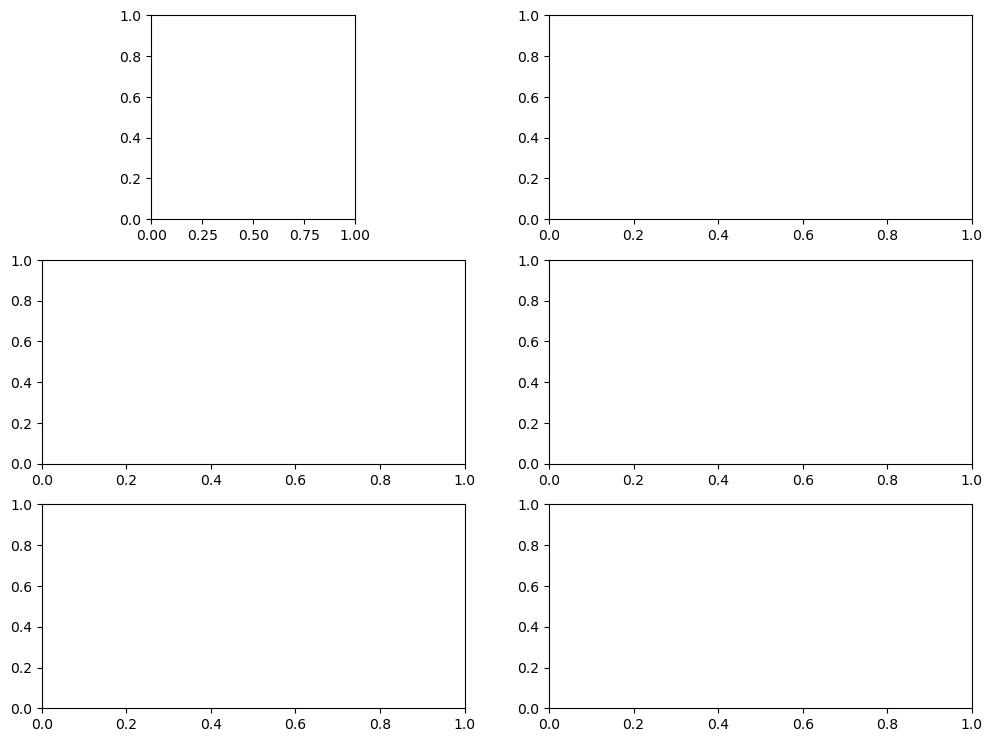

In [55]:

n_lon = 239
# Plot first 3 EOFs and their time series
fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows, 2 columns


for i in range(3):  # Plot first 3 EOFs and their time series
    # EOF spatial pattern
    eof_pattern = pca.components_[i].reshape(len(data_centered[0]))
    im = axes[i, 0].imshow(eof_pattern, cmap='RdBu_r')
    axes[i, 0].set_title(f'EOF {i+1} ({explained_variance[i]*100:.2f}% variance)')
    fig.colorbar(im, ax=axes[i, 0])
    
    # Principal component time series
    axes[i, 1].plot(transformed_data[:, i], label=f'PC {i+1}', color='b')
    axes[i, 1].set_title(f'PC {i+1} Time Series')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

:::{tip} _Exercise 4:_ Physical interpretation
What do you see in your plots? Try to identify signals in you EOF and PC time series plots. Discuss in your team what the physical meaning of the different signals in the first few modes could be.
:::


_____

(h-data-reconstruction)=
# 3. Reconstruct the data from the dominant modes of EOF pattern and principal component time series


:::{tip} _Exercise 5:_ Derive criteria for significance of modes from singular values 
For data reconstruction, only the dominant modes are used, so that most of the variance of the data is retained, but espressed in fewer basis functions (dimensionality reduction). This step also acts as a **filter** on the data.
- Plot the singular values / variance explained for each mode. Can you guess from the curve which values might be containing signal?
- Plot the explained variance cummulative. Another strategy is, to make sure to expalin a certain level of variance in the reconstruction, e.g. 90%. How does this compare to the significant number of modes you found from the previous plot?
- For a more rigorous way to choose the modes, one possibility is to test if the time series are significantly different from white noise (unless you are very familiar with statistical tests, you can skip this for this homework).


:::{tip} _Exercise 6:_ Reconstruct the data with selected modes from the previous exercise
Using the modes you selected above, reconstruct the data. In case you were not sure in your selection, test with different numbers of modes. Look at a few monthly snapshots and compare to the original data (e.g. plot the differences) what do you observe?
:::

:::{attention} Congratulations! 
You have completed the entire process of data analysis and data reconstruction with PCA on GRACE data until here. The following chapters and exercises look into adapting, refining, and optimising this process.
:::

_____

(h-gaps)=
# 4. Gap handling

:::{tip} _Exercise 7:_ Explore different ways of handling gaps
- There are differnet ways of handling gaps in the data before performing EOF analysis. In the exercises above, the missing months have just been left out. Another approach is to interpolate data to fill missing months. Please try this for shorter gaps and see how this effects your EOF analysis results. Plot your new EOFs and PC time series below.
- Handling the gap between GRACE and GRACE-FO is more tricky. Try removing one more month, so that you have a gap of an entire year instead of 11 months. Does it make a difference? (plot EOFs and PCs again)
- You might see now, that it makes sense to arrange you EOF and PC plots in compact way. Maybe refine you plot arrangement from above.
- There are several scientific publications making use of EOF analysis to bridge the gap between GRACE and GRACE-FO. They often target the spherical harmonic coefficients (and using other GRACE solutions). But this works for our mascon data, too. Can you think of and sketch at leat one approach, how the gap between the two missions could be bridged by using EOF analysis?
:::

_____

(h-regional)=
# 5. EOF analysis of selected regions

:::{tip} _Exercise 8:_ Perform EOF analysis of a region only
- Select any region which you think might contain an interesting signal

- EOF analysis of the continents only should lead to a more clear signal in the first modes -> try and compare the results

:::

_____

(h-outlook-feedback)=
# 6. Outlook and feedback

&#9989; Task:
: Finally, I'd again really appreciate your feedback on this JupyterNotebook homework

In [2]:
from IPython.display import IFrame
IFrame('https://docs.googlae.com/forms/d/e/1FAIpQLSc2lg39Siu95lTva0OIIN6tVEAfTls-uAp0LNg-Wz7YZHH3VQ/viewform?embedded=true', 640, 1657)